In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

sys.path.append('/user_data/mmhender/imStat/code/')
import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [16]:
from model_fitting import initialize_fitting
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
which_prf_grid=2
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, \
                                                     which_grid=which_prf_grid) 

models.shape

number of pRFs: 1114
most extreme RF positions:
[-0.55 -0.55  0.04]
[ 0.  0. 10.]


(1114, 3)

In [10]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'alexnet_Conv5'
# fitting_type = 'alexnet_all_conv'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/alexnet_Conv5/Oct-24-2021_1712_01/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'alexnet_layer_name'])
subject = 1
volume_space = 1
fitting_type = alexnet
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (30000,)
voxel_index: len 1
voxel_roi: len 4
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1
models: shape (1114, 3)
best_losses: shape (19738, 1)
best_lambdas: shape (19738, 1)
best_params: len 6
lambdas: shape (9,)
val_cc: shape (19738, 1)
val_r2: shape (19738, 1)
partial_masks: shape 

In [11]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [12]:
port=33333
summary_plots.plot_summary_pycortex(out=out, subject=subject, fitting_type=fitting_type, \
                                port=port, roi_def=roi_def)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


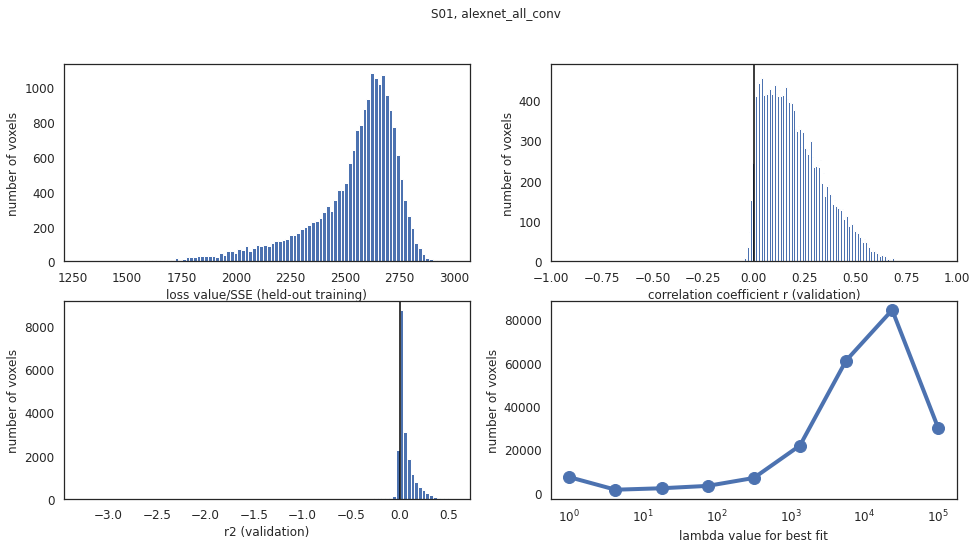

In [11]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

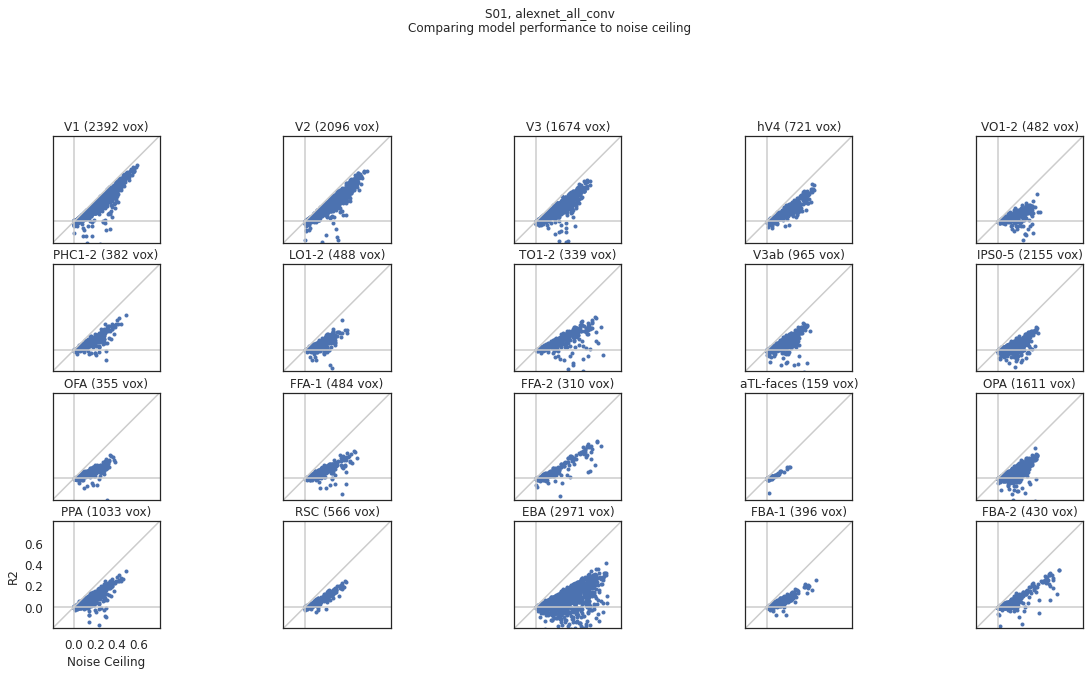

In [12]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_r2_vs_nc(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                            fig_save_folder=fig_save_folder,axlims = [-0.2, 0.8])

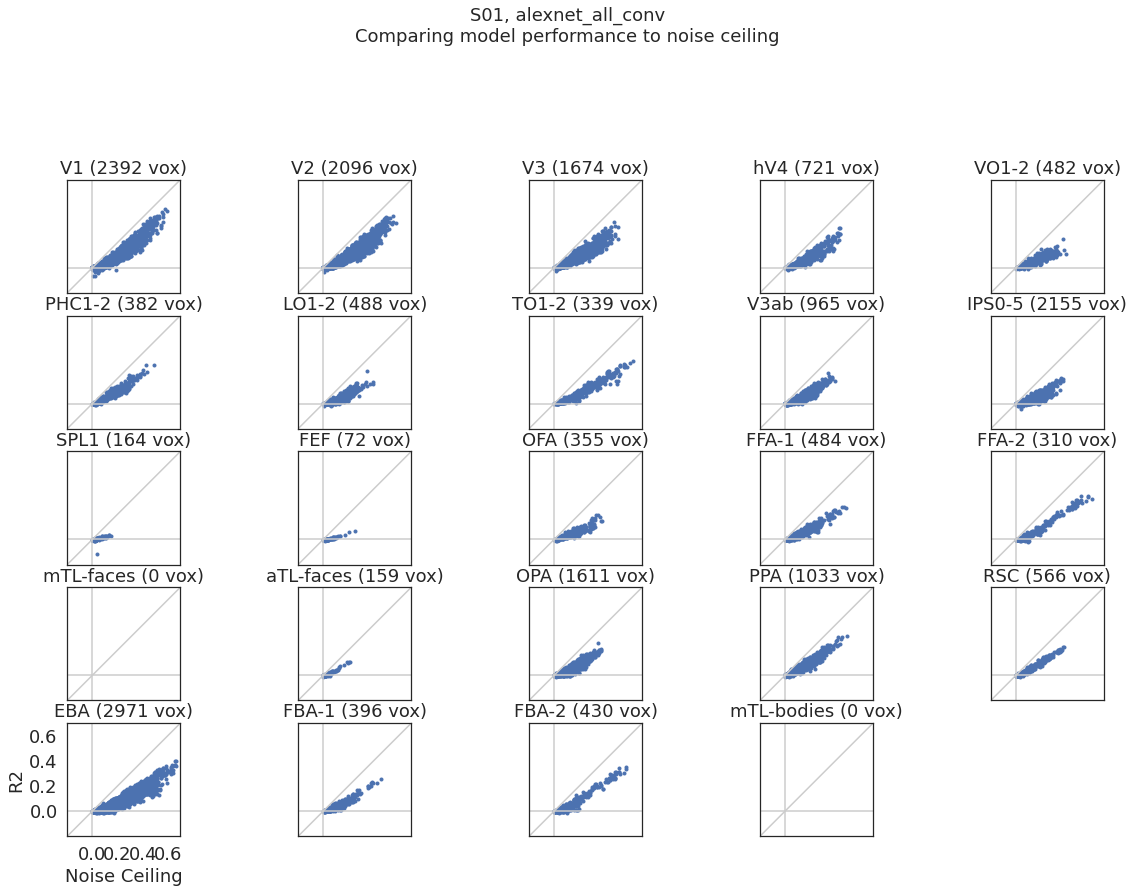

In [21]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,0])*out['val_cc'][:,0]**2
val_r2 = out['val_r2'][:,9]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size)
plt.gcf().subplots_adjust(bottom=0.5)
# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.png'))
#     plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.pdf'))


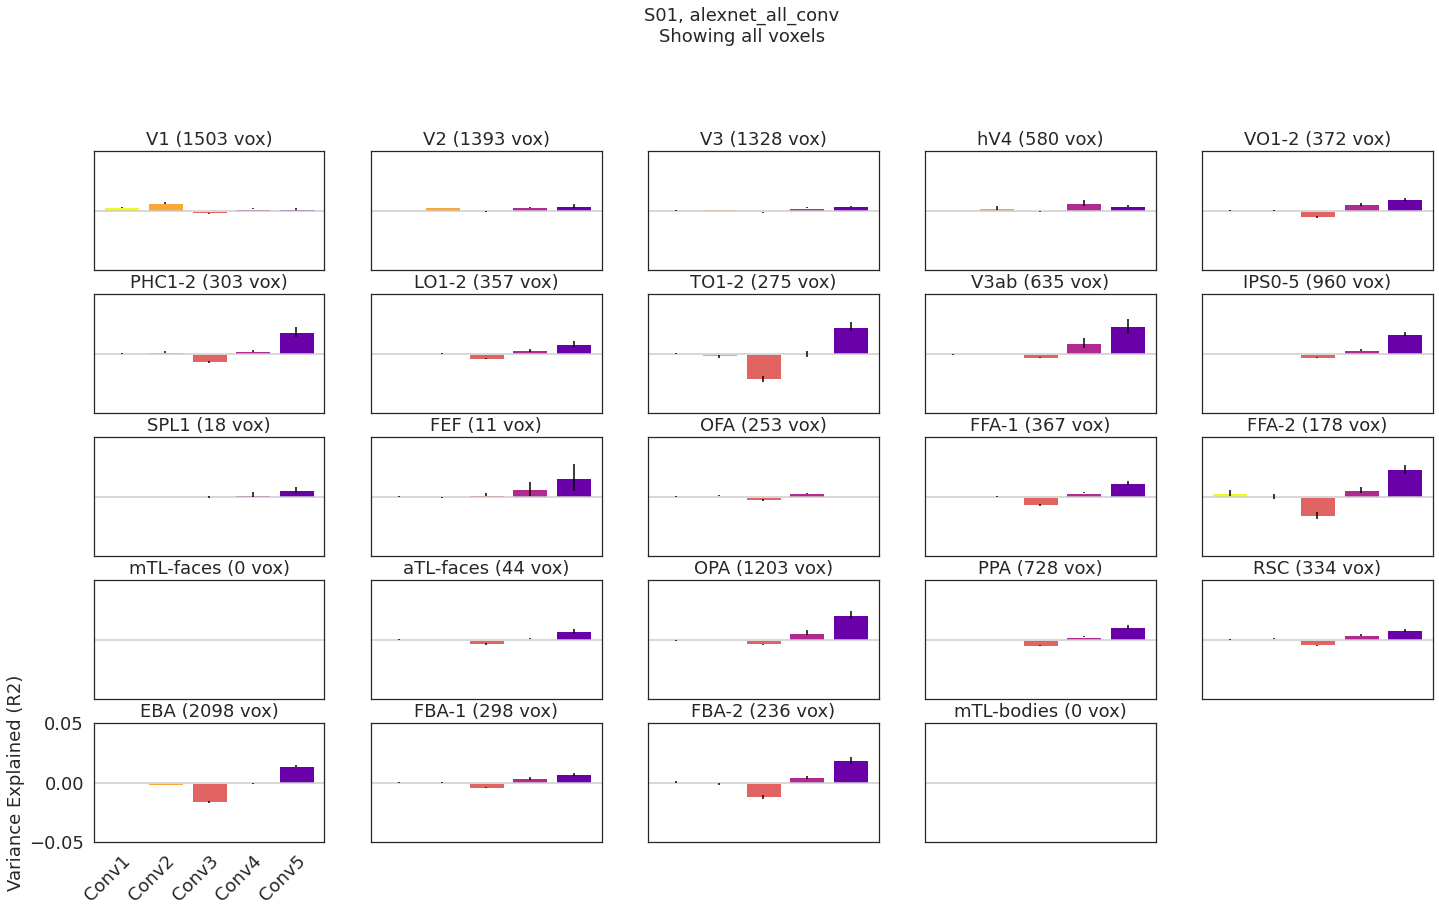

In [22]:
ve_names = ['Conv%d'%(ll+1) for ll in range(5)]
var_expl = np.tile(out['val_r2'][:,0:1], [1,5]) - out['val_r2'][:,[2,4,6,8,10]]

colors = cm.plasma(np.linspace(0,1,6))
colors = np.flipud(colors)

inds2use = out['val_r2'][:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.05, 0.05])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)


In [23]:

port=33333

vox2plot = (out['val_r2'][:,0]>0)

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from gabor FWRF)', 'pRF angle (from gabor FWRF)', \
         'pRF size (from gabor FWRF)', \
        'R2 concat']
maps = [best_ecc_deg, best_angle_deg, best_size_deg, out['val_r2'][:,0], out['val_cc'][:,0]]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn', 'PuBu']
mins = [0,0,0, 0]
maxes = [7, 360, 4, 0.8]

names +=['R2 Conv%s alone'%(ll+1) for ll in range(5)]
maps +=[np.sqrt(out['val_r2'][:,pp]) for pp in [1,3,5,7,9]]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0,0]
maxes += [0.8, 0.8, 0.8, 0.8, 0.8]

names += ['Unique: Conv%d'%(ll+1) for ll in range(5)]
var_expl = np.tile(out['val_r2'][:,0:1], [1,5]) - out['val_r2'][:,[2,4,6,8,10]]
maps += [var_expl[:,ll] for ll in range(5)]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0,0]
maxes += [0.2, 0.2, 0.2, 0.2, 0.2]


plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


In [6]:
out['partial_version_names']

['full_combined_model',
 'just_Conv1_ReLU',
 'leave_out_Conv1_ReLU',
 'just_Conv2_ReLU',
 'leave_out_Conv2_ReLU',
 'just_Conv3_ReLU',
 'leave_out_Conv3_ReLU',
 'just_Conv4_ReLU',
 'leave_out_Conv4_ReLU',
 'just_Conv5_ReLU',
 'leave_out_Conv5_ReLU']

In [35]:
np.mean(out['val_r2'], axis=0)

array([0.05237936, 0.03504649, 0.05236261, 0.05078351, 0.05198713,
       0.03419761, 0.06205347, 0.05720016, 0.05077564, 0.05150901,
       0.04465135], dtype=float32)

Stopping server


In [28]:
np.sum(np.isnan(out['val_cc']), axis=0)

array([3840,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [30]:
badvox = np.where(np.isnan(out['val_r2'][:,0]))[0]
len(badvox)

3840

In [33]:
out['best_params'][0][badvox,0,:]

array([[-0.20263158, -0.31842105,  0.04      ],
       [ 0.55      , -0.55      ,  0.40000001],
       [ 0.        , -0.55      ,  0.28787428],
       ...,
       [-0.55      ,  0.55      ,  0.40000001],
       [-0.39285714, -0.23571429,  0.10730783],
       [-0.33      , -0.11      ,  0.14910375]])

In [ ]:
np.any(np.isnan())

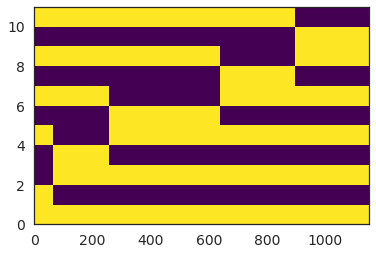

In [7]:
plt.figure();
plt.pcolormesh(out['partial_masks'])

In [25]:
np.array(out['partial_version_names'])[np.array([1,3,5,7,9])]

array(['just_Conv1_ReLU', 'just_Conv2_ReLU', 'just_Conv3_ReLU',
       'just_Conv4_ReLU', 'just_Conv5_ReLU'], dtype='<U20')